In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
import datetime
from meteostat import Point, Hourly
import matplotlib.pyplot as plt

In [2]:
# File path
file_path = r"C:\Users\vanes\Desktop\RL thesis topics\missing values prediction\code\household_power_consumption.csv"

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path, parse_dates={'date_time': ['Date', 'Time']}, dayfirst=True, na_values='?')

# Convert numeric columns to numeric types and handle non-numeric entries
numeric_columns = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Calculate 'Sub_metering_4'
df['Sub_metering_4'] = (df['Global_active_power'] * 1000 / 60) - (df['Sub_metering_1'] + df['Sub_metering_2'] + df['Sub_metering_3'])

# Set 'date_time' as the index and sort it
df['date_time'] = pd.to_datetime(df['date_time'], dayfirst=True)
df.set_index('date_time', inplace=True)
df.sort_index(inplace=True)


In [3]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
date_time,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266667
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333333
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566667
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800000
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.100000


In [4]:
# We ckeck how many missing values we have
df.isna().sum()


Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
Sub_metering_4           25979
dtype: int64

In [5]:
#check the min date
print(df.index.min())
#check the max date
print(df.index.max())

2006-12-16 17:24:00
2010-11-26 21:02:00


In [6]:
# Identify the longest gap of missing values in 'Global_active_power'
na_groups = df['Global_active_power'].notna().cumsum()[df['Global_active_power'].isna()]
len_consecutive_na = na_groups.groupby(na_groups).agg(len)
longest_na_gap_index = len_consecutive_na.idxmax()
start_date_gap = df[df['Global_active_power'].notna().cumsum() == longest_na_gap_index].index.min()
end_date_gap = df[df['Global_active_power'].notna().cumsum() == longest_na_gap_index].index.max()

print("Gap Start Date:", start_date_gap)
print("Gap End Date:", end_date_gap)

Gap Start Date: 2010-08-17 21:01:00
Gap End Date: 2010-08-22 21:27:00


In [7]:
#resample data to Hourly
df = df.resample('H').sum()

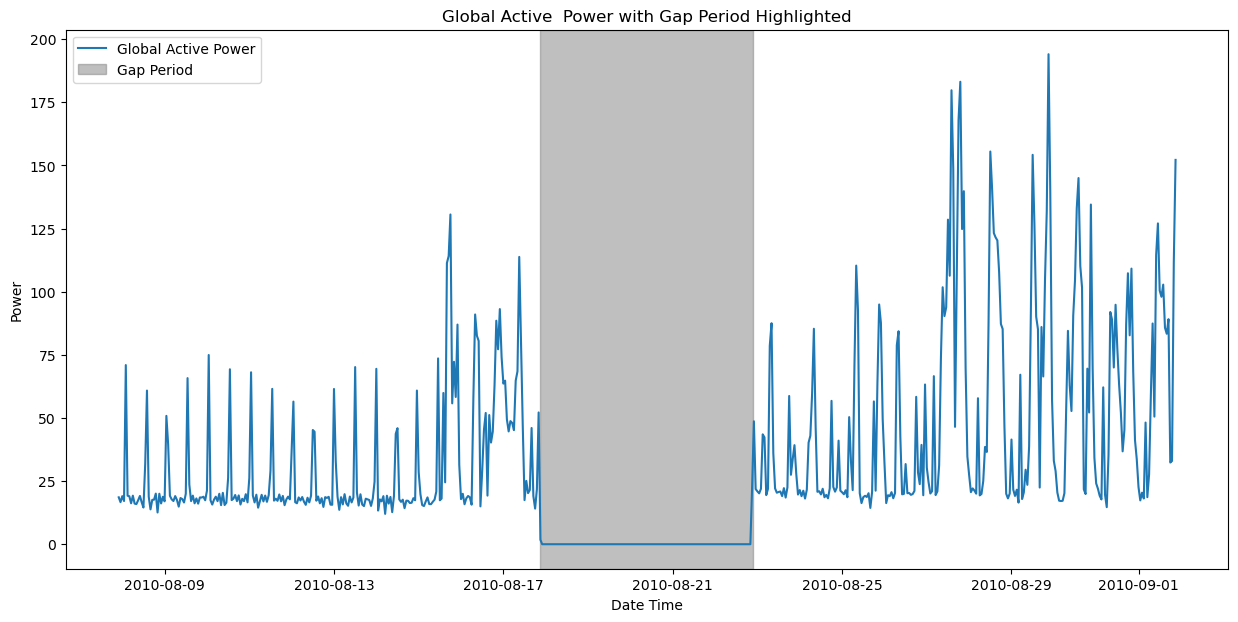

In [8]:
# Define the period to plot
period_start = start_date_gap - pd.Timedelta(days=10)
period_end = end_date_gap + pd.Timedelta(days=10)

# Filter the data for the plotting period
plot_data = df[(df.index >= period_start) & (df.index <= period_end)]

# Plot 'Global_active_power' and 'Global_reactive_power'
plt.figure(figsize=(15, 7))
plt.plot(plot_data.index, plot_data['Global_active_power'], label='Global Active Power')
# Add a shaded area for the gap period
plt.axvspan(start_date_gap, end_date_gap, color='grey', alpha=0.5, label='Gap Period')

plt.legend()
plt.title('Global Active  Power with Gap Period Highlighted')
plt.xlabel('Date Time')
plt.ylabel('Power')
plt.show()

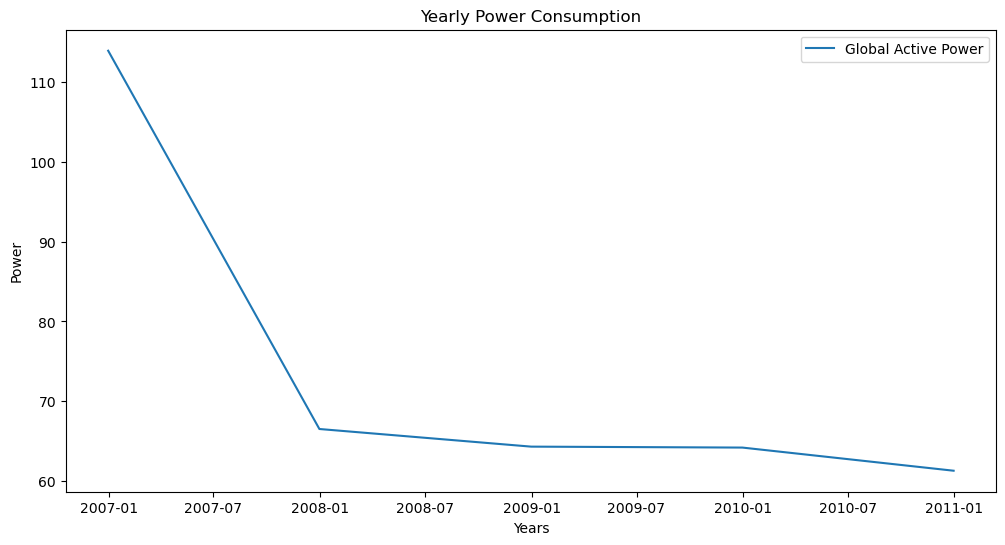

In [9]:
# Resample data yearly and plot
df_monthly = df.resample('Y').mean()  # Resample to yearly mean
plt.figure(figsize=(12, 6))
plt.plot(df_monthly.index, df_monthly['Global_active_power'], label='Global Active Power')
plt.title('Yearly Power Consumption')
plt.xlabel('Years')
plt.ylabel('Power')
plt.legend()
plt.show()

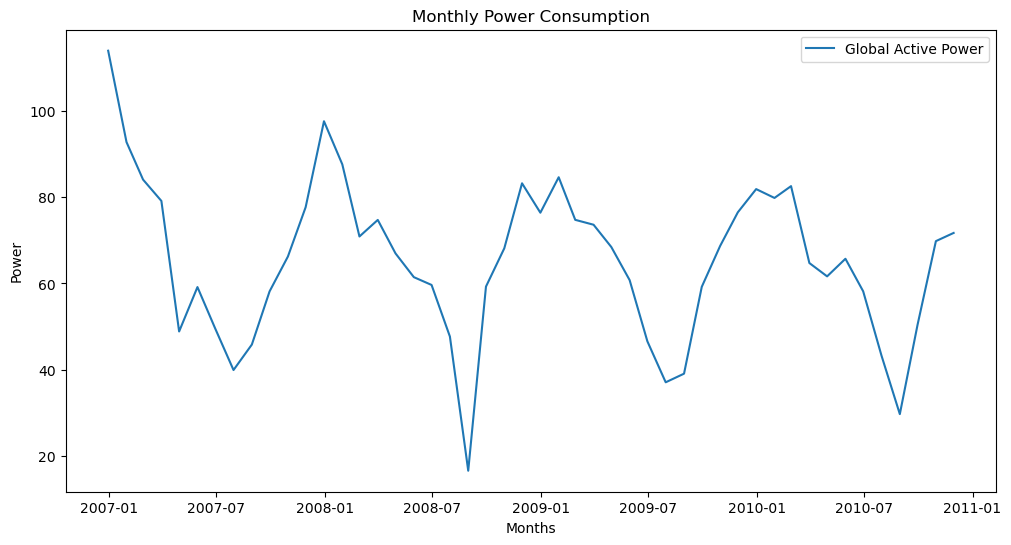

In [10]:
# Resample data monthly and plot
df_monthly = df.resample('M').mean()  # Resample to monthly mean
plt.figure(figsize=(12, 6))
plt.plot(df_monthly.index, df_monthly['Global_active_power'], label='Global Active Power')
plt.title('Monthly Power Consumption')
plt.xlabel('Months')
plt.ylabel('Power')
plt.legend()
plt.show()

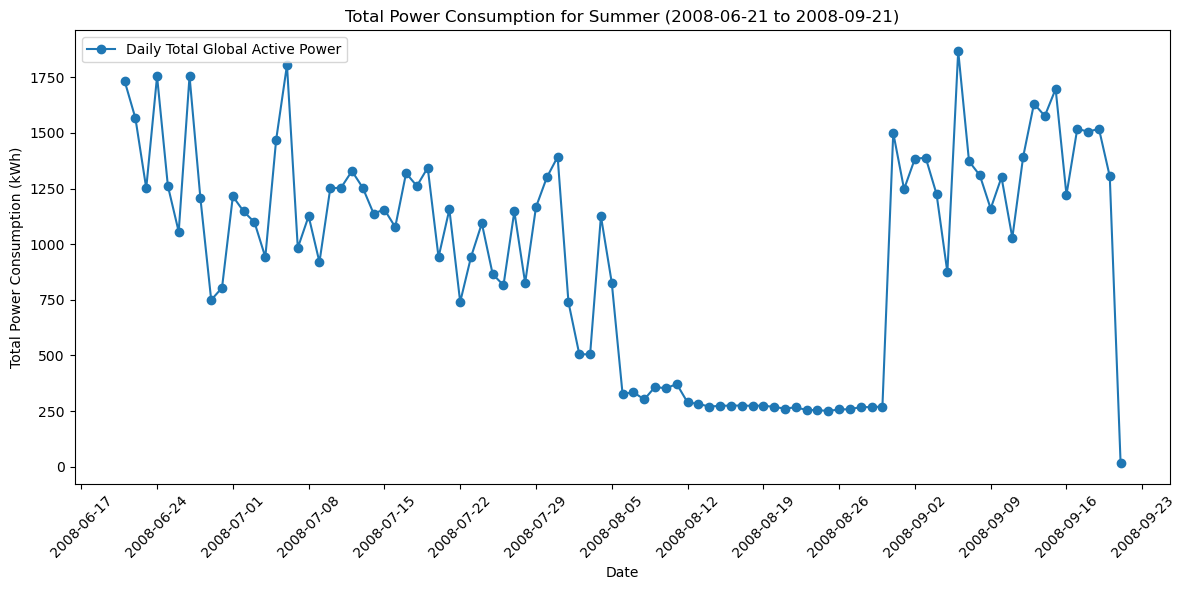

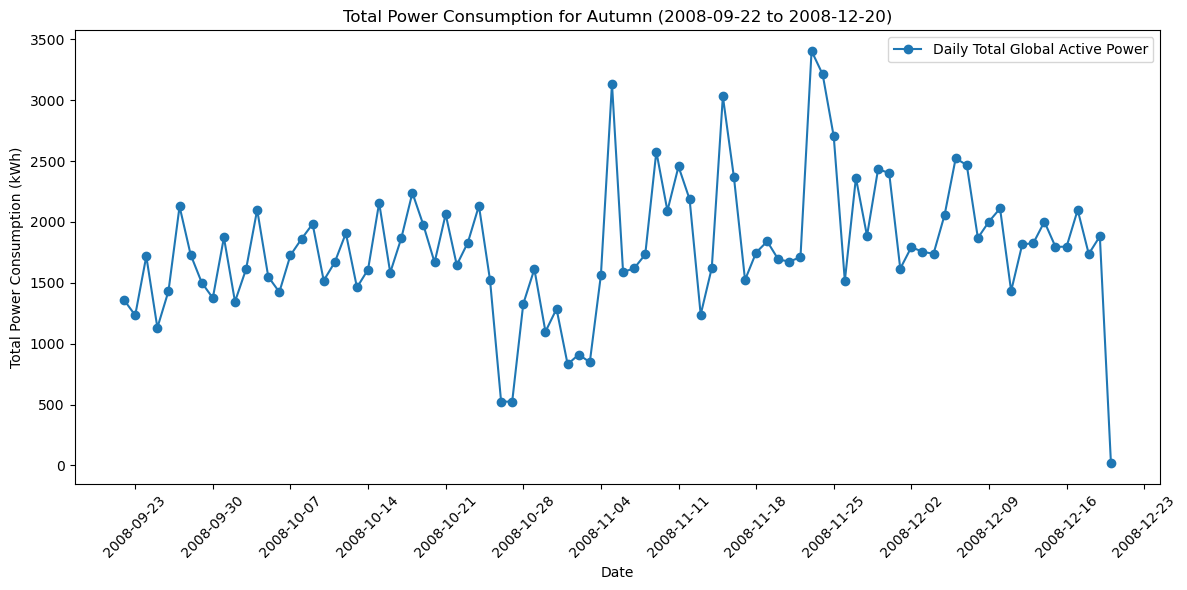

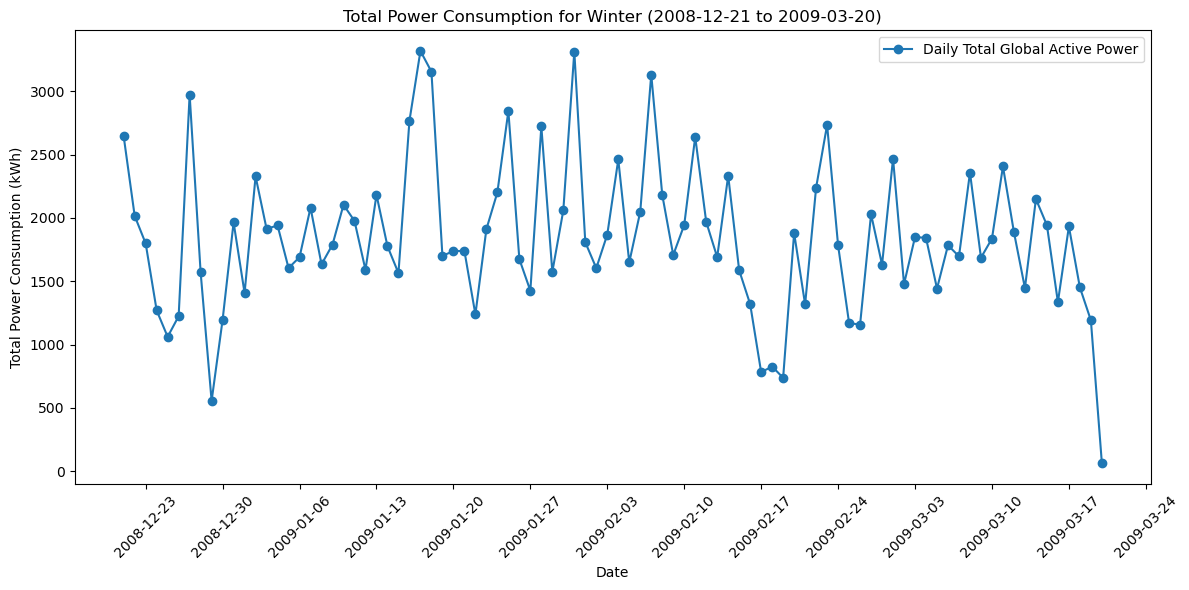

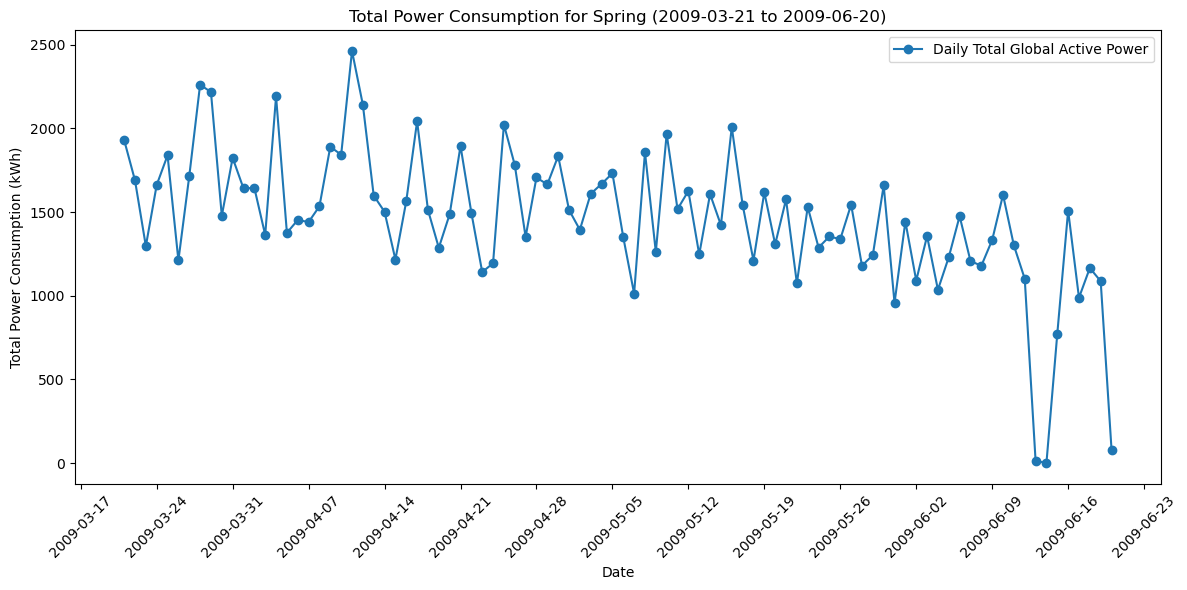

In [11]:
import matplotlib.dates as mdates


# Define date ranges for each season
seasons = {
    'Summer': ('2008-06-21', '2008-09-21'),
    'Autumn': ('2008-09-22', '2008-12-20'),
    'Winter': ('2008-12-21', '2009-03-20'),
    'Spring': ('2009-03-21', '2009-06-20')
}

# Plot for each season
for season, (start_date, end_date) in seasons.items():
    # Filter data for the specific season date range
    season_data = df[(df.index >= pd.to_datetime(start_date)) & (df.index <= pd.to_datetime(end_date))]
    
    # Resample the data to daily frequency and calculate the total daily power consumption
    daily_total = season_data['Global_active_power'].resample('D').sum()

    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.plot(daily_total.index, daily_total, label='Daily Total Global Active Power', marker='o')
    
    # Format x-axis to show date only
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))  # Set major ticks to every week
    
    plt.title(f'Total Power Consumption for {season} ({start_date} to {end_date})')
    plt.xlabel('Date')
    plt.ylabel('Total Power Consumption (kWh)')
    plt.legend()
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()